<a href="https://colab.research.google.com/github/lMonolitol/FinalSoluWeb/blob/main/ClasificaciondeBullying.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🚀 Sistema de Detección de Bullying

🤖 CNN BULLYING DETECTION SYSTEM
1. 🔍 Verificar Dataset
2. 🏋️  Entrenar Modelo
3. 📊 Evaluar Modelo
4. 🖼️  Analizar Imagen
5. 📂 Analizar Carpeta Test
6. ❌ Salir
Opción (1-6): 1
🔍 VERIFICACIÓN DEL DATASET

📁 TRAIN:
  ✅ bullying: 60 imágenes
  ✅ no_bullying: 40 imágenes
  📊 Total train: 100 imágenes

📁 VALIDATION:
  ✅ bullying: 5 imágenes
  ✅ no_bullying: 1 imágenes
  📊 Total validation: 6 imágenes

📁 TEST:
  ✅ Imágenes: 7

📊 RESUMEN:
  • Entrenamiento/Validación: 106
  • Test: 7
⚠️ Dataset pequeño (106 imágenes)

⚖️ BALANCE:
   • Bullying: 60 (60.0%)
   • No Bullying: 40 (40.0%)

🤖 CNN BULLYING DETECTION SYSTEM
1. 🔍 Verificar Dataset
2. 🏋️  Entrenar Modelo
3. 📊 Evaluar Modelo
4. 🖼️  Analizar Imagen
5. 📂 Analizar Carpeta Test
6. ❌ Salir
Opción (1-6): 2
🤖 ENTRENAMIENTO DEL MODELO CNN
⚖️ ANÁLISIS DE BALANCE DEL DATASET:

📁 TRAIN:

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 119,489 (466.75 KB)

 Trainable params: 118,785 (464.00 KB)

 Non-trainable params: 704 (2.75 KB)


🏋️ Iniciando entrenamiento...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4500 - loss: 1.4418
Epoch 1: val_accuracy improved from -inf to 0.16667, saving model to /content/drive/MyDrive/bullying_dataset/modelo_bullying_cnn.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.4480 - loss: 1.4348 - val_accuracy: 0.1667 - val_loss: 0.7443 - learning_rate: 1.0000e-04
Epoch 2/50
 1/12 ━━━━━━━━━━━━━━━━━━━━ 5s 479ms/step - accuracy: 0.2500 - loss: 1.5880
Epoch 2: val_accuracy did not improve from 0.16667
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2500 - loss: 1.5880 - val_accuracy: 0.1667 - val_loss: 0.7511 - learning_rate: 1.0000e-04
Epoch 3/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.4936 - loss: 1.0648
Epoch 3: val_accuracy did not improve from 0.16667
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 578ms/step - accuracy: 0.4925 - loss: 1.0711 - val_accuracy: 0.1667 - val_loss: 0.8048 - learning_rate: 1.0000e-04
Epoch 4/50
 1/12 ━━━━━━━━━━━━━━━━━━━━ 5s 523ms/step - accuracy: 0.2500 - loss: 1.5039
Epoch 4: val_accuracy did not improve from 0.16667
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2500 - loss: 1.5039 - val_accuracy: 0.1667 - val_loss: 0.8084 - learning_rate: 1.0000e-04
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.5298 - loss: 0.8421
Epoch 5: val_accuracy did not improve from 0.16667
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 618ms/step - accuracy: 0.5308 - loss: 0.8455 - val_accuracy: 0.1667 - val_loss: 0.8395 - learning_rate: 1.0000e-04
Epoch 6/50
 1/12 ━━━━━━━━━━━━━━━━━━━━ 5s 492ms/step - accuracy: 0.5000 - loss: 1.1556
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

E

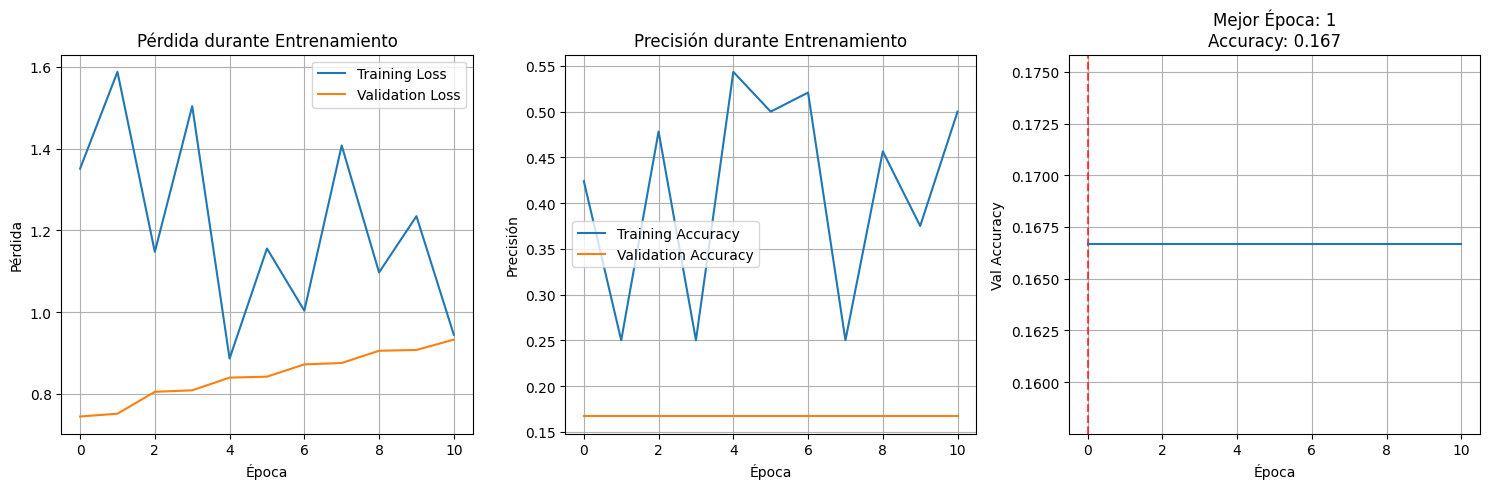


📊 ANÁLISIS FINAL:
Training Accuracy: 0.500
Validation Accuracy: 0.167
Diferencia: 0.333
⚠️ POSIBLE OVERFITTING detectado!

🤖 CNN BULLYING DETECTION SYSTEM
1. 🔍 Verificar Dataset
2. 🏋️  Entrenar Modelo
3. 📊 Evaluar Modelo
4. 🖼️  Analizar Imagen
5. 📂 Analizar Carpeta Test
6. ❌ Salir
Opción (1-6): 3
📊 EVALUACIÓN DEL MODELO


Found 100 images belonging to 2 classes.
🔍 Mapeo de clases: {'bullying': 0, 'no_bullying': 1}
Found 6 images belonging to 2 classes.
📂 Evaluando 6 imágenes
📊 Clases validación: {'bullying': 0, 'no_bullying': 1}
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

🔍 ANÁLISIS DE PREDICCIONES:
❌ bullying/bullying10.jpg        | Real: No Bullying  | Pred: Bullying     | Score: 0.533
❌ bullying/bullying6.jpg         | Real: No Bullying  | Pred: Bullying     | Score: 0.537
❌ bullying/bullying7.jpg         | Real: No Bullying  | Pred: Bullying     | Score: 0.537
❌ bullying/bullying8.jpg         | Real: No Bullying  | Pred: Bullying     | Score: 0.536
❌ bullying/bullying9.jpg         | Real: No Bullying  | Pred: Bullying     | Score: 0.534
✅ no_bullying/nobullying5.jpg    | Real: Bullying     | Pred: Bullying     | Score: 0.532


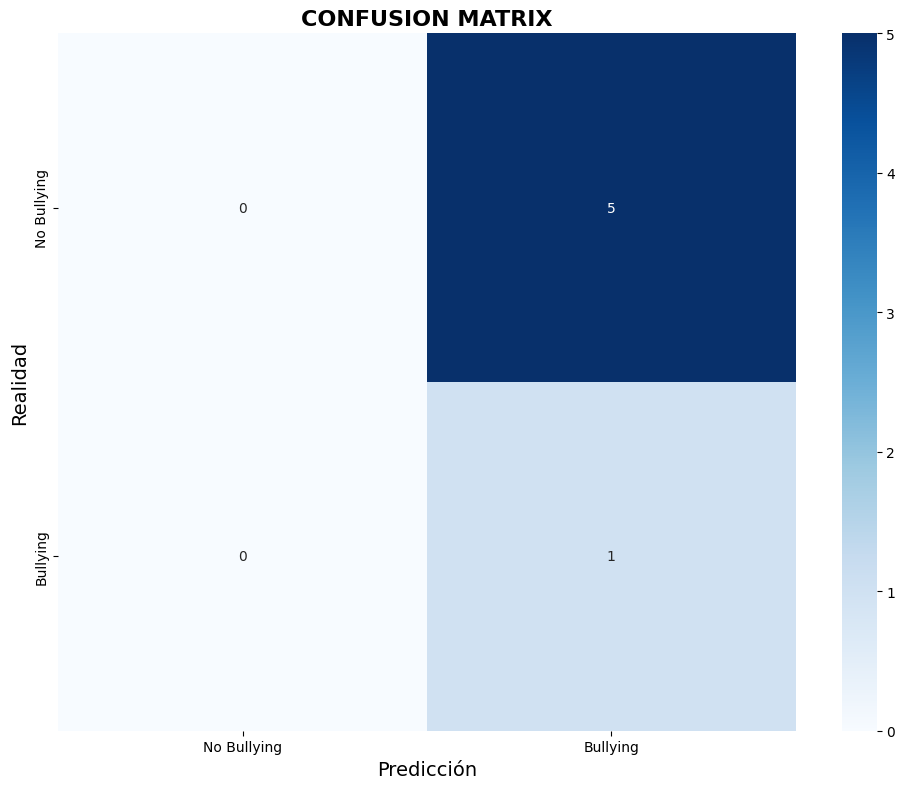


🎯 MÉTRICAS:
📊 Accuracy:    0.167
🎯 Precision:   0.167
🔍 Recall:      1.000
🛡️ Specificity: 0.000
⚖️ F1-Score:    0.286

📋 MATRIZ:
TN: 0, FP: 5, FN: 0, TP: 1

🤖 CNN BULLYING DETECTION SYSTEM
1. 🔍 Verificar Dataset
2. 🏋️  Entrenar Modelo
3. 📊 Evaluar Modelo
4. 🖼️  Analizar Imagen
5. 📂 Analizar Carpeta Test
6. ❌ Salir
Opción (1-6): 4
🖼️ ANÁLISIS DE IMAGEN INDIVIDUAL


Found 100 images belonging to 2 classes.
🔍 Mapeo de clases: {'bullying': 0, 'no_bullying': 1}
📷 Ruta de la imagen: /content/drive/MyDrive/bullying_dataset/test/test7.jpg

🟢 NO HAY BULLYING
📊 Confianza: 53.1%
📈 Score: 0.5309
🔧 Clase pred: 1
💡 ✅ Imagen segura


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


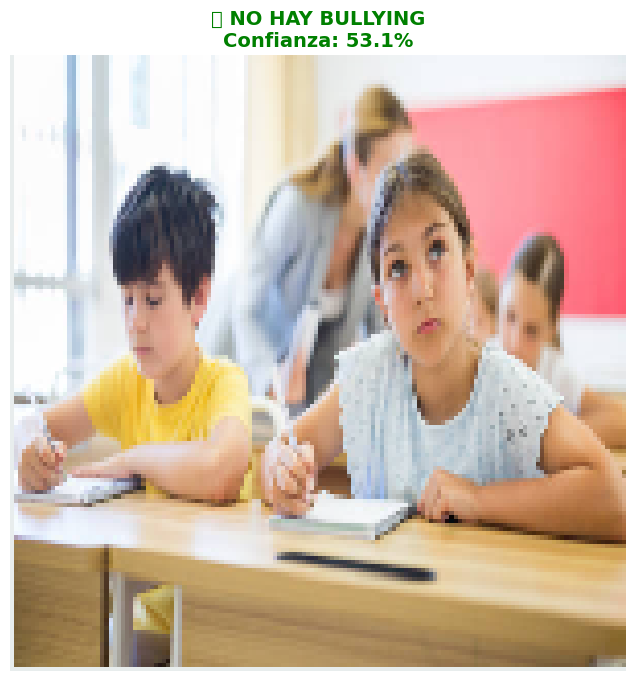


🤖 CNN BULLYING DETECTION SYSTEM
1. 🔍 Verificar Dataset
2. 🏋️  Entrenar Modelo
3. 📊 Evaluar Modelo
4. 🖼️  Analizar Imagen
5. 📂 Analizar Carpeta Test
6. ❌ Salir
Opción (1-6): 5
🖼️ ANÁLISIS MASIVO DE CARPETA TEST


Found 100 images belonging to 2 classes.
🔍 Mapeo de clases: {'bullying': 0, 'no_bullying': 1}
📊 Analizando 7 imágenes...
  1/7 - 🟢 test1.jpg                      | NO BULLYING  |  53.2% | Score: 0.532
  2/7 - 🟢 test2.jpg                      | NO BULLYING  |  53.6% | Score: 0.536
  3/7 - 🟢 test3.jpg                      | NO BULLYING  |  54.0% | Score: 0.540
  4/7 - 🟢 test4.jpg                      | NO BULLYING  |  53.2% | Score: 0.532
  5/7 - 🟢 test5.jpg                      | NO BULLYING  |  53.0% | Score: 0.530
  6/7 - 🟢 test6.jpg                      | NO BULLYING  |  53.1% | Score: 0.531
  7/7 - 🟢 test7.jpg                      | NO BULLYING  |  53.1% | Score: 0.531

📊 RESUMEN:
📷 Total: 7
🔴 Bullying: 0 (0.0%)
🟢 No bullying: 7 (100.0%)

🤖 CNN BULLYING DETECTION SYSTEM
1. 🔍 Verificar Dataset
2. 🏋️  Entrenar Modelo
3. 📊 Evaluar Modelo
4. 🖼️  Analizar Imagen
5. 📂 Analizar Carpeta Test
6. ❌ Salir


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.preprocessing import image
import glob

drive.mount('/content/drive')
ruta_base = '/content/drive/MyDrive/bullying_dataset'
ruta_train = os.path.join(ruta_base, 'train')
ruta_validation = os.path.join(ruta_base, 'validation')
ruta_test = os.path.join(ruta_base, 'test')
ruta_modelo = os.path.join(ruta_base, 'modelo_bullying_cnn.h5')

TAMANO_IMG = 150
TAMANO_LOTE = 8

def crear_modelo_cnn():
    modelo = tf.keras.models.Sequential([
        Input(shape=(TAMANO_IMG, TAMANO_IMG, 3)),

        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

    modelo.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return modelo

def obtener_mapeo_clases():
    """Función centralizada para obtener el mapeo de clases del entrenamiento"""
    if os.path.exists(ruta_train):
        temp_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
            ruta_train, target_size=(TAMANO_IMG, TAMANO_IMG),
            batch_size=1, class_mode='binary', shuffle=False
        )
        class_indices = temp_gen.class_indices
        print(f"🔍 Mapeo de clases: {class_indices}")
        return class_indices
    else:
        print("⚠️ No se pudo obtener mapeo de clases, usando por defecto")
        return {'bullying': 1, 'no_bullying': 0}

def balancear_dataset():
    print("⚖️ ANÁLISIS DE BALANCE DEL DATASET:")
    print("=" * 50)

    for carpeta_nombre in ['train', 'validation']:
        carpeta_path = os.path.join(ruta_base, carpeta_nombre)
        if os.path.exists(carpeta_path):
            bullying_path = os.path.join(carpeta_path, 'bullying')
            no_bullying_path = os.path.join(carpeta_path, 'no_bullying')

            if os.path.exists(bullying_path) and os.path.exists(no_bullying_path):
                bullying_count = len([f for f in os.listdir(bullying_path)
                                    if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
                no_bullying_count = len([f for f in os.listdir(no_bullying_path)
                                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

                total = bullying_count + no_bullying_count
                if total > 0:
                    bullying_pct = (bullying_count / total) * 100
                    no_bullying_pct = (no_bullying_count / total) * 100

                    print(f"\n📁 {carpeta_nombre.upper()}:")
                    print(f"  🔴 Bullying: {bullying_count} ({bullying_pct:.1f}%)")
                    print(f"  🟢 No Bullying: {no_bullying_count} ({no_bullying_pct:.1f}%)")

                    if abs(bullying_pct - 50) > 30:
                        print(f"  ⚠️ DATASET MUY DESBALANCEADO!")

def entrenar_modelo():
    print("🤖 ENTRENAMIENTO DEL MODELO CNN")
    print("=" * 40)

    if not os.path.exists(ruta_train) or not os.path.exists(ruta_validation):
        print("❌ No se encontraron las carpetas necesarias.")
        return

    balancear_dataset()

    datagen_train = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )

    datagen_validation = ImageDataGenerator(rescale=1./255)

    train_generator = datagen_train.flow_from_directory(
        ruta_train,
        target_size=(TAMANO_IMG, TAMANO_IMG),
        batch_size=TAMANO_LOTE,
        class_mode='binary',
        shuffle=True
    )

    validation_generator = datagen_validation.flow_from_directory(
        ruta_validation,
        target_size=(TAMANO_IMG, TAMANO_IMG),
        batch_size=TAMANO_LOTE,
        class_mode='binary',
        shuffle=False
    )

    print(f"📊 Clases encontradas: {train_generator.class_indices}")
    print(f"📚 Imágenes de entrenamiento: {train_generator.samples}")
    print(f"🔍 Imágenes de validación: {validation_generator.samples}")

    if train_generator.samples < 200:
        print("\n⚠️ ADVERTENCIA: Dataset muy pequeño!")

    modelo = crear_modelo_cnn()
    print("\n🧠 Arquitectura CNN:")
    modelo.summary()

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=0.00001,
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            ruta_modelo,
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]

    print("\n🏋️ Iniciando entrenamiento...")

    steps_per_epoch = max(1, train_generator.samples // TAMANO_LOTE)
    validation_steps = max(1, validation_generator.samples // TAMANO_LOTE)

    history = modelo.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        callbacks=callbacks,
        verbose=1
    )

    print(f"✅ Modelo CNN guardado en: {ruta_modelo}")

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Pérdida durante Entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Precisión durante Entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Precisión')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    best_epoch = np.argmax(history.history['val_accuracy'])
    best_val_acc = np.max(history.history['val_accuracy'])
    plt.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.7)
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Mejor Época: {best_epoch+1}\nAccuracy: {best_val_acc:.3f}')
    plt.xlabel('Época')
    plt.ylabel('Val Accuracy')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]

    print(f"\n📊 ANÁLISIS FINAL:")
    print(f"Training Accuracy: {final_train_acc:.3f}")
    print(f"Validation Accuracy: {final_val_acc:.3f}")
    print(f"Diferencia: {abs(final_train_acc - final_val_acc):.3f}")

    if abs(final_train_acc - final_val_acc) > 0.2:
        print("⚠️ POSIBLE OVERFITTING detectado!")

    return modelo

def evaluar_modelo():
    print("📊 EVALUACIÓN DEL MODELO")
    print("=" * 40)

    if not os.path.exists(ruta_modelo):
        print("❌ No se encontró el modelo entrenado.")
        return

    if not os.path.exists(ruta_validation):
        print("❌ No se encontró la carpeta 'validation'.")
        return

    modelo = load_model(ruta_modelo)
    class_indices = obtener_mapeo_clases()

    datagen_validation = ImageDataGenerator(rescale=1./255)

    validation_generator = datagen_validation.flow_from_directory(
        ruta_validation,
        target_size=(TAMANO_IMG, TAMANO_IMG),
        batch_size=1,
        class_mode='binary',
        shuffle=False
    )

    print(f"📂 Evaluando {validation_generator.samples} imágenes")
    print(f"📊 Clases validación: {validation_generator.class_indices}")

    predicciones_raw = modelo.predict(validation_generator, verbose=1)
    predicciones_binarias = (predicciones_raw > 0.5).astype(int).flatten()
    etiquetas_reales = validation_generator.classes

    print(f"\n🔍 ANÁLISIS DE PREDICCIONES:")
    filenames = validation_generator.filenames
    for i in range(min(10, len(predicciones_raw))):
        pred_prob = predicciones_raw[i][0]
        pred_class = predicciones_binarias[i]
        real_class = etiquetas_reales[i]
        filename = filenames[i]

        pred_label = "Bullying" if pred_class == 1 else "No Bullying"
        real_label = "Bullying" if real_class == 1 else "No Bullying"

        correcto = "✅" if pred_class == real_class else "❌"
        print(f"{correcto} {filename:30} | Real: {real_label:12} | Pred: {pred_label:12} | Score: {pred_prob:.3f}")

    cm = confusion_matrix(etiquetas_reales, predicciones_binarias)

    plt.figure(figsize=(10, 8))
    labels = ['No Bullying', 'Bullying']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, cbar=True)
    plt.title('CONFUSION MATRIX', fontsize=16, fontweight='bold')
    plt.xlabel('Predicción', fontsize=14)
    plt.ylabel('Realidad', fontsize=14)
    plt.tight_layout()
    plt.show()

    if len(cm.ravel()) == 4:
        TN, FP, FN, TP = cm.ravel()

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        print("\n🎯 MÉTRICAS:")
        print("=" * 30)
        print(f"📊 Accuracy:    {accuracy:.3f}")
        print(f"🎯 Precision:   {precision:.3f}")
        print(f"🔍 Recall:      {recall:.3f}")
        print(f"🛡️ Specificity: {specificity:.3f}")
        print(f"⚖️ F1-Score:    {f1:.3f}")
        print("=" * 30)

        print(f"\n📋 MATRIZ:")
        print(f"TN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}")
    else:
        print("⚠️ Confusion matrix incompleta")

def predecir_imagen(modelo, ruta_img, class_indices):
    """Función unificada para predecir una imagen"""
    img = image.load_img(ruta_img, target_size=(TAMANO_IMG, TAMANO_IMG))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediccion_raw = modelo.predict(img_array, verbose=0)[0][0]

    # Lógica consistente: score > 0.5 = clase 1, score <= 0.5 = clase 0
    if prediccion_raw > 0.5:
        pred_class = 1
        confianza = prediccion_raw * 100
    else:
        pred_class = 0
        confianza = (1 - prediccion_raw) * 100

    # Determinar etiqueta basada en el mapeo de clases
    if class_indices.get('bullying') == 1:
        es_bullying = (pred_class == 1)
    else:
        es_bullying = (pred_class == 0)

    return {
        'es_bullying': es_bullying,
        'confianza': confianza,
        'score': prediccion_raw,
        'pred_class': pred_class,
        'img': img
    }

def clasificar_imagen_individual():
    print("🖼️ ANÁLISIS DE IMAGEN INDIVIDUAL")
    print("=" * 40)

    if not os.path.exists(ruta_modelo):
        print("❌ No se encontró el modelo entrenado.")
        return

    modelo = load_model(ruta_modelo)
    class_indices = obtener_mapeo_clases()

    ruta_img = input("📷 Ruta de la imagen: ")

    if not os.path.exists(ruta_img):
        print("❌ Imagen no encontrada.")
        return

    try:
        resultado = predecir_imagen(modelo, ruta_img, class_indices)

        if resultado['es_bullying']:
            resultado_txt = "🔴 BULLYING DETECTADO"
            color = "red"
            recomendacion = "⚠️ Revisión recomendada"
        else:
            resultado_txt = "🟢 NO HAY BULLYING"
            color = "green"
            recomendacion = "✅ Imagen segura"

        print(f"\n{resultado_txt}")
        print("=" * 40)
        print(f"📊 Confianza: {resultado['confianza']:.1f}%")
        print(f"📈 Score: {resultado['score']:.4f}")
        print(f"🔧 Clase pred: {resultado['pred_class']}")
        print(f"💡 {recomendacion}")

        plt.figure(figsize=(10, 8))
        plt.imshow(resultado['img'])
        plt.title(f'{resultado_txt}\nConfianza: {resultado["confianza"]:.1f}%',
                 fontsize=14, fontweight='bold', color=color)
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"❌ Error: {str(e)}")

def analizar_carpeta_test():
    print("🖼️ ANÁLISIS MASIVO DE CARPETA TEST")
    print("=" * 50)

    if not os.path.exists(ruta_modelo):
        print("❌ No se encontró el modelo entrenado.")
        return

    if not os.path.exists(ruta_test):
        print("❌ No se encontró la carpeta 'test'.")
        return

    modelo = load_model(ruta_modelo)
    class_indices = obtener_mapeo_clases()

    extensiones = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']
    imagenes = []
    for ext in extensiones:
        imagenes.extend(glob.glob(os.path.join(ruta_test, ext)))
        imagenes.extend(glob.glob(os.path.join(ruta_test, ext.upper())))

    if len(imagenes) == 0:
        print("❌ No se encontraron imágenes.")
        return

    print(f"📊 Analizando {len(imagenes)} imágenes...")

    resultados = []
    bullying_detectado = 0

    for i, ruta_img in enumerate(imagenes, 1):
        try:
            resultado = predecir_imagen(modelo, ruta_img, class_indices)
            nombre_archivo = os.path.basename(ruta_img)

            if resultado['es_bullying']:
                clasificacion = "BULLYING"
                bullying_detectado += 1
                emoji = "🔴"
            else:
                clasificacion = "NO BULLYING"
                emoji = "🟢"

            resultados.append({
                'archivo': nombre_archivo,
                'clasificacion': clasificacion,
                'confianza': resultado['confianza'],
                'score': resultado['score'],
                'emoji': emoji
            })

            print(f"{i:3d}/{len(imagenes)} - {emoji} {nombre_archivo:<30} | {clasificacion:<12} | {resultado['confianza']:5.1f}% | Score: {resultado['score']:.3f}")

        except Exception as e:
            print(f"❌ Error en {os.path.basename(ruta_img)}: {str(e)}")

    print(f"\n📊 RESUMEN:")
    print(f"📷 Total: {len(resultados)}")
    print(f"🔴 Bullying: {bullying_detectado} ({bullying_detectado/len(resultados)*100:.1f}%)")
    print(f"🟢 No bullying: {len(resultados)-bullying_detectado} ({(len(resultados)-bullying_detectado)/len(resultados)*100:.1f}%)")

    return resultados

def verificar_dataset():
    print("🔍 VERIFICACIÓN DEL DATASET")
    print("=" * 40)

    total_imagenes = 0

    for carpeta in ['train', 'validation']:
        ruta_carpeta = os.path.join(ruta_base, carpeta)
        print(f"\n📁 {carpeta.upper()}:")

        if os.path.exists(ruta_carpeta):
            carpeta_total = 0

            for clase in ['bullying', 'no_bullying']:
                ruta_clase = os.path.join(ruta_carpeta, clase)
                if os.path.exists(ruta_clase):
                    num_imgs = len([f for f in os.listdir(ruta_clase)
                                  if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))])
                    print(f"  ✅ {clase}: {num_imgs} imágenes")
                    carpeta_total += num_imgs
                else:
                    print(f"  ❌ {clase}: No existe")

            print(f"  📊 Total {carpeta}: {carpeta_total} imágenes")
            total_imagenes += carpeta_total
        else:
            print(f"  ❌ Carpeta {carpeta} no existe")

    print(f"\n📁 TEST:")
    if os.path.exists(ruta_test):
        extensiones = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.tiff']
        imagenes_test = []
        for ext in extensiones:
            imagenes_test.extend(glob.glob(os.path.join(ruta_test, ext)))
            imagenes_test.extend(glob.glob(os.path.join(ruta_test, ext.upper())))
        print(f"  ✅ Imágenes: {len(imagenes_test)}")
    else:
        print(f"  ❌ Carpeta test no existe")
        imagenes_test = []

    print(f"\n📊 RESUMEN:")
    print(f"  • Entrenamiento/Validación: {total_imagenes}")
    print(f"  • Test: {len(imagenes_test)}")

    if total_imagenes < 200:
        print(f"⚠️ Dataset pequeño ({total_imagenes} imágenes)")

    if os.path.exists(os.path.join(ruta_train, 'bullying')) and os.path.exists(os.path.join(ruta_train, 'no_bullying')):
        train_bullying = len([f for f in os.listdir(os.path.join(ruta_train, 'bullying'))
                             if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        train_no_bullying = len([f for f in os.listdir(os.path.join(ruta_train, 'no_bullying'))
                                if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

        if train_bullying > 0 and train_no_bullying > 0:
            ratio = train_bullying / train_no_bullying
            print(f"\n⚖️ BALANCE:")
            print(f"   • Bullying: {train_bullying} ({train_bullying/(train_bullying+train_no_bullying)*100:.1f}%)")
            print(f"   • No Bullying: {train_no_bullying} ({train_no_bullying/(train_bullying+train_no_bullying)*100:.1f}%)")

            if ratio > 2 or ratio < 0.5:
                print(f"   ⚠️ DESBALANCEADO!")

def mostrar_menu():
    print("\n🤖 CNN BULLYING DETECTION SYSTEM")
    print("=" * 40)
    print("1. 🔍 Verificar Dataset")
    print("2. 🏋️  Entrenar Modelo")
    print("3. 📊 Evaluar Modelo")
    print("4. 🖼️  Analizar Imagen")
    print("5. 📂 Analizar Carpeta Test")
    print("6. ❌ Salir")
    print("=" * 40)

def main():
    print("🚀 Sistema de Detección de Bullying")

    while True:
        mostrar_menu()
        opcion = input("Opción (1-6): ")

        if opcion == '1':
            verificar_dataset()
        elif opcion == '2':
            entrenar_modelo()
        elif opcion == '3':
            evaluar_modelo()
        elif opcion == '4':
            clasificar_imagen_individual()
        elif opcion == '5':
            analizar_carpeta_test()
        elif opcion == '6':
            print("👋 ¡Adiós!")
            break
        else:
            print("❌ Opción inválida.")

if __name__ == "__main__":
    main()